<a href="https://colab.research.google.com/github/duraichellam001-tech/ev-range-model/blob/main/notebooks/03_dataset_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal


In [3]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ev-range-model/data/UDDS.csv")
df.columns = ["time","speed"]
df.head()

Mounted at /content/drive


,time,speed
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


In [4]:
df["speed"] = df["speed"]*1.6 # Miles to kmph conversion

In [5]:
import numpy as np
import pandas as pd

def generate_variations(df, speed_factors=[0.8, 1.0, 1.2]):
    dfs = []
    for sf in speed_factors:
        df_var = df.copy()
        df_var['speed'] = df['speed'] * sf
        df_var['v'] = df_var['speed'] * (1000/3600)
        df_var['a'] = df_var['v'].diff().fillna(0)

        # re-use your Day-4→6 physics functions
        df_var['F_rr'] = 1600*9.81*0.012
        df_var['F_aero'] = 0.5*1.225*2.2*0.28*(df_var['v']**2)
        df_var['F_acc'] = 1600*df_var['a']
        df_var['F_total'] = df_var['F_rr']+df_var['F_aero']+df_var['F_acc']
        df_var['P_wheel'] = df_var['F_total']*df_var['v']
        df_var['P_batt'] = df_var['P_wheel']/0.9
        df_var['P_batt'] = df_var['P_batt'].clip(lower=0)
        df_var['E_Wh'] = df_var['P_batt']/3600
        df_var['E_Wh_cum'] = df_var['E_Wh'].cumsum()
        df_var['dist_m'] = df_var['v']
        df_var['dist_km_cum'] = (df_var['dist_m']/1000).cumsum()

        total_Wh = df_var['E_Wh_cum'].iloc[-1]
        total_km = df_var['dist_km_cum'].iloc[-1]
        wh_per_km = total_Wh/total_km

        dfs.append({
            'speed_factor': sf,
            'avg_speed': df_var['speed'].mean(),
            'max_speed': df_var['speed'].max(),
            'std_speed': df_var['speed'].std(),
            'percent_idle': (df_var['speed']<1).mean(),
            'avg_accel': df_var['a'][df_var['a']>0].mean(),
            'avg_decel': abs(df_var['a'][df_var['a']<0].mean()),
            'accel_std': df_var['a'].std(),
            'peak_accel': df_var['a'].max(),
            'cycle_duration': len(df_var),
            'total_distance_km': total_km,
            'energy_Wh': total_Wh,
            'wh_per_km': wh_per_km
        })
    return pd.DataFrame(dfs)

dataset = generate_variations(df)
print(dataset)


   speed_factor  avg_speed  max_speed  std_speed  percent_idle  avg_accel  \
0           0.8  25.004655     72.576  18.826658      0.197378   0.401307   
1           1.0  31.255819     90.720  23.533322      0.196650   0.501634   
2           1.2  37.506983    108.864  28.239987      0.195921   0.601961   

   avg_decel  accel_std  peak_accel  cycle_duration  total_distance_km  \
0   0.459602   0.496770    1.173333            1373           9.536498   
1   0.574503   0.620962    1.466667            1373          11.920622   
2   0.689404   0.745155    1.760000            1373          14.304747   

     energy_Wh   wh_per_km  
0  1187.205757  124.490750  
1  1772.295684  148.674763  
2  2497.618506  174.600681  


In [7]:
dataset.to_csv('/content/drive/My Drive/Colab Notebooks/ev-range-model/data/training_dataset.csv', index=False)


In [9]:
pd.read_csv('/content/drive/My Drive/Colab Notebooks/ev-range-model/data/training_dataset.csv').head()


,speed_factor,avg_speed,max_speed,std_speed,percent_idle,avg_accel,avg_decel,accel_std,peak_accel,cycle_duration,total_distance_km,energy_Wh,wh_per_km
0,0.8,25.004655,72.576,18.826658,0.197378,0.401307,0.459602,0.496770,1.173333,1373,9.536498,1187.205757,124.490750
1,1.0,31.255819,90.720,23.533322,0.196650,0.501634,0.574503,0.620962,1.466667,1373,11.920622,1772.295684,148.674763
2,1.2,37.506983,108.864,28.239987,0.195921,0.601961,0.689404,0.745155,1.760000,1373,14.304747,2497.618506,174.600681


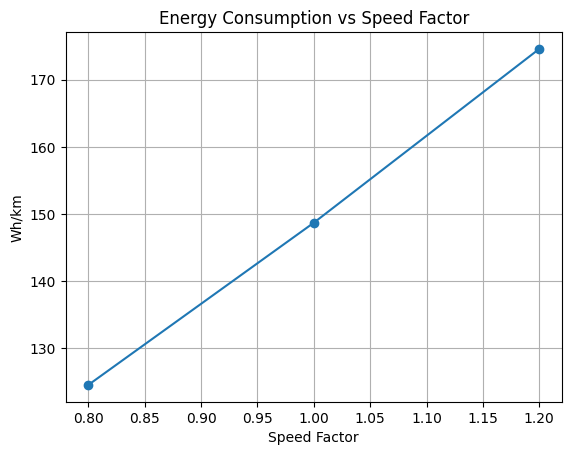

In [10]:
import matplotlib.pyplot as plt
plt.plot(dataset['speed_factor'], dataset['wh_per_km'], marker='o')
plt.xlabel('Speed Factor')
plt.ylabel('Wh/km')
plt.title('Energy Consumption vs Speed Factor')
plt.grid()
plt.show()
